Здесь воспроизведен эксперимент из статьи [**Ramachandran, et.al.: Selecting optimal source for transfer learning in Bayesian optimisation.**](https://books.google.ru/books?id=McpmDwAAQBAJ&pg=PA42&lpg=PA42&dq=Ramachandran+Selecting+optimal+source+for+transfer+learning+in+Bayesian+optimisation.&source=bl&ots=xHhpuHu1Nq&sig=ynRb1s6aEE9YaKHSvVH3OfybL34&hl=en&sa=X&ved=2ahUKEwj00v27kPXeAhWPKCwKHQLSBsQQ6AEwBHoECAQQAQ#v=onepage&q=Ramachandran%20Selecting%20optimal%20source%20for%20transfer%20learning%20in%20Bayesian%20optimisation.&f=false)

Задача: допустим y - бимодальная двумерная гауссиана с с модами [0.7;0.7] и [2.7;2.7]

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
a = multivariate_normal([0.7,0.7], np.eye(2))

b = multivariate_normal([2.7,2.7], 0.25*np.eye(2))

Итоговая функция (a+b) / max(a+b) нормировка важна, т.к иначе функцию источник не найти, а так же потому что мы моделируем accuracy

In [3]:
def f(data):
    return (a.pdf(data) + b.pdf(data))/(a.pdf([2.7,2.7]) + b.pdf([2.7,2.7]))

In [4]:
theta_1 = np.linspace(-1., 4, 30)
theta_2 = np.linspace(-1, 4, 30)

X, Y = np.meshgrid(theta_1,theta_2)
data = np.append(X[...,np.newaxis], Y[...,np.newaxis], axis=-1)
Z = f(data)

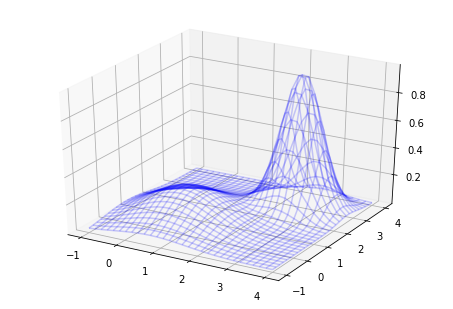

In [5]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X, Y,
    Z.reshape(X.shape), alpha=0.2, color='b')


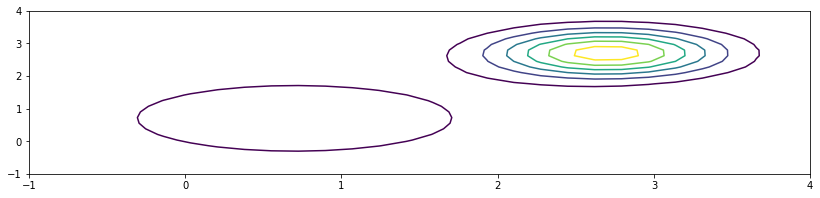

In [6]:
fig, axes = plt.subplots(ncols=1, figsize=(14, 3))
axes.contour(X,Y,Z)

In [7]:
def rbf_k(X, Y, theta):
    return np.exp(-(((X[:,np.newaxis,:] - Y[np.newaxis,:,:])**2)\
                    * theta[np.newaxis, np.newaxis,:]).sum(axis=-1))


def predict(X_train, T_train, X_test, theta, beta, kernel):
    k = kernel(X_train, X_test, theta)
    K = kernel(X_train, X_train, theta)
    C = K + 1 / beta * np.eye(X_train.shape[0])
    C_rev = np.linalg.inv(C)
    mu = k.T.dot(C_rev.dot(T_train))
    sigma = np.diag(kernel(X_test, X_test, theta))+ 1 / beta - np.diag(k.T.dot(C_rev.dot(k)))
    return mu.ravel(), sigma.ravel()

Генерируем данные и делим тест и трэйн

In [8]:
data = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

Z = Z.ravel()

X_train, X_test, y_train, y_test = train_test_split(data, Z, test_size=0.95, shuffle=True, random_state=42)

In [9]:
mask = y_train < 0.1
y_train = y_train[mask]
X_train = X_train[mask]

mask = y_test > 0.1
y_test = y_test[mask]
X_test = X_test[mask]

In [10]:
X_train.shape

(23, 2)

In [11]:
x_test = X_test

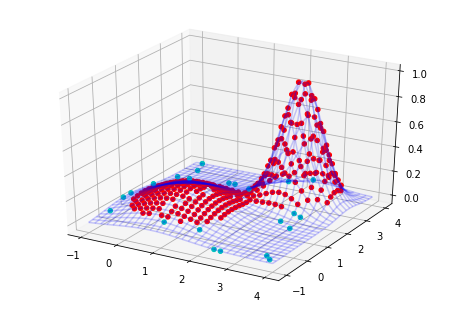

In [12]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, Z.reshape(X.shape), alpha=0.2, color='b')
ax.scatter([x[0] for x in X_test], [x[1] for x in X_test], y_test, c='r',
        marker='o', alpha=1.0)
ax.scatter([x[0] for x in X_train], [x[1] for x in X_train], y_train, c='c',
        marker='o', alpha=1.0)

Пробуем Байес Оптимизацию

Попробуем несколько aquisition функций, Expected Improvement и GP-UCB(как в статье).   
Важно увидеть что EI минимизирует функцию поэтому следует взять значения функции со знаком минус

$ y(x) = \mu(x) + \sigma(x) \epsilon, \epsilon \sim N(0,1) $  
$ EI = \int \limits_{- \inf}^{(t_{min} - \mu(x))/\sigma(x)} (t_{min} - \mu(x) - \sigma(x) \epsilon)
\rho(\epsilon)d\epsilon = (t_{min} - \mu(x))\Phi((t_{min} - \mu(x))/\sigma(x)) + 
\frac{\sigma(x)}{\sqrt{2\pi}} \int \limits_{- \inf}^{(t_{min} - \mu(x))/\sigma(x)} \exp(-\frac{\epsilon^2}{2})
d-\frac{\epsilon^2}{2} = 
(t_{min} - \mu(x))\Phi((t_{min} - \mu(x))/\sigma(x)) + \sigma(x)\rho((t_{min} - \mu(x))/\sigma(x))$

In [13]:
gp = GaussianProcessRegressor()

In [28]:
from scipy import stats

def get_expected_improvement(X_train, T_train, X_test, theta, beta, kernel):
    mu, sigma = predict(X_train, T_train, X_test, theta, beta, kernel)
    t_min = T_train.min()
    #print(t_min.shape, mu.shape, sigma.shape)
    point = (t_min - mu)/sigma
    return stats.norm.cdf(point)*(t_min - mu) + sigma*stats.norm.pdf(point)

def get_gp_ucb_simple(X_train, T_train, X_test, theta, beta, forget, kernel):
    mu, sigma = predict(X_train, T_train, X_test, theta, beta, kernel)
    return mu + sigma * np.sqrt(forget)

def get_gp_ucb_advanced(X_train, T_train, X_test, theta, beta, delta, kernel, iteration):
    mu, sigma = predict(X_train, T_train, X_test, theta, beta, kernel)
    rdelta = np.min(np.max(0,delta), 1)
    forget = 2*(2*np.log(iteration) + 2*np.log(np.pi)\
    - np.log(rdelta) + np.log(6) + np.log(X_test.shape[0] + X_train.shape[0]))
    return mu + sigma * np.sqrt(forget)

def get_rbf_grad_log_theta(X, Y, beta, theta):
    K = kernel(X, X, theta)
    C = K + 1 / beta * np.eye(X.shape[0])
    C_rev = np.linalg.inv(C)
    d_C = K[...,np.newaxis] * (-(X[:,np.newaxis,:] - X[np.newaxis,:,:])**2)
    aid = (C_rev[:,np.newaxis,:,np.newaxis] * d_C[np.newaxis, ...]).sum(2)
    arg2 = (Y[:,np.newaxis] * ((aid[:,np.newaxis,:,:] * C_rev[np.newaxis,:,:,np.newaxis]).sum(2))).sum(0)
    arg2 = (arg2 * Y[:, np.newaxis]).sum(0)
    #print(arg2.shape, np.trace(aid).shape)
    #return (0.5 * (-np.trace(aid)[:,np.newaxis] + arg2) * theta).ravel()
    return 0.5 * (-np.trace(aid) + arg2).ravel()

def get_log_likelihood(X, Y, beta, theta):
    K = kernel(X, X, theta)
    C = K + 1 / beta * np.eye(X.shape[0])
    C_rev = np.linalg.inv(C)
    return (-0.5 * (np.log(np.linalg.det(C)) + (Y*(C_rev[:,:,np.newaxis] * Y[:,np.newaxis,:]).sum(0)).sum(0)\
                    + Y.shape[0] * np.log(2*np.pi))).ravel()

In [198]:
from scipy import stats

def get_expected_improvement_sklearn(T_train, mu, sigma):
    t_min = T_train.min()
    point = (t_min - mu)/sigma
    return stats.norm.cdf(point)*(t_min - mu) + sigma*stats.norm.pdf(point)

def get_gp_ucb_simple_sklearn( mu, sigma, forget):
    return mu + sigma * np.sqrt(forget)

def get_gp_ucb_advanced_sklearn( mu, sigma, delta, iteration, D, forget):
    rdelta = np.min(np.max(0,delta), 1)
    forget = 2*(2*np.log(iteration) + 2*np.log(np.pi)\
    - np.log(rdelta) + np.log(6) + np.log(D))
    return mu + sigma * np.sqrt(forget)

In [15]:
beta = 50
kernel = rbf_k
theta = np.array([0.1,0.1])
num_tuning_steps = 500

In [89]:
gp = GaussianProcessRegressor()

Обычная Байесовская оптимизация без обновления параметров ядра

In [154]:
x_train = X_train.copy()
t_train = y_train.copy()
x_test = X_test
num_new_points = 30
for _ in range(num_new_points):
    # calculating expected improvement for all points
    expected_improvement = get_expected_improvement(x_train, -t_train, x_test, theta, beta, kernel)
    mu, sigma = predict(x_train, t_train, x_test, theta, beta, kernel)
    # adding new point
    x_train = np.vstack([x_train, np.array(x_test[np.argmax(expected_improvement)])])
    t_train = f(x_train)

In [155]:
t_train[-30:]

array([0.13966108, 0.13892856, 0.24606813, 0.2487157 , 0.2487157 ,
       0.2487157 , 0.2487157 , 0.2487157 , 0.2487157 , 0.2487157 ,
       0.2487157 , 0.2487157 , 0.2487157 , 0.2487157 , 0.2487157 ,
       0.2487157 , 0.2487157 , 0.2487157 , 0.2487157 , 0.2487157 ,
       0.2487157 , 0.2487157 , 0.2487157 , 0.2487157 , 0.2487157 ,
       0.2487157 , 0.2487157 , 0.2487157 , 0.2487157 , 0.2487157 ])

In [156]:
mu, sigma = predict(x_train, t_train, data, theta, beta, kernel)

In [157]:
get_expected_improvement(x_train, -t_train, x_train[-30:], np.exp(log_theta), beta, kernel)

array([2.98851514e-09, 2.98851514e-09, 2.98851514e-09, 2.98851514e-09,
       2.98851514e-09, 2.98851514e-09, 2.98851514e-09, 2.98851514e-09,
       2.98851514e-09, 2.98851514e-09, 2.98851514e-09, 2.98851514e-09,
       2.98851514e-09, 2.98851514e-09, 2.98851514e-09, 2.98851514e-09,
       2.98851514e-09, 2.98851514e-09, 2.98851514e-09, 2.98851514e-09,
       2.98851514e-09, 2.98851514e-09, 2.98851514e-09, 2.98851514e-09,
       2.98851514e-09, 2.98851514e-09, 2.98851514e-09, 2.98851514e-09,
       2.98851514e-09, 2.98851514e-09])

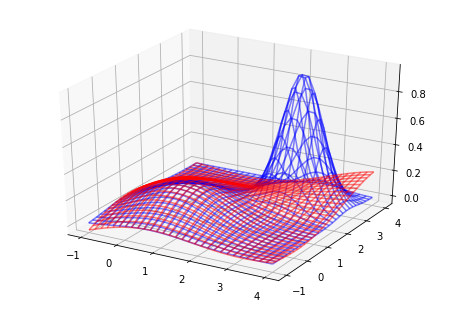

In [159]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, Z.reshape(X.shape), alpha=0.5, color='b')
ax.plot_wireframe(X, Y, mu.reshape(X.shape), alpha=0.5, color='r')


Обычная Байесовская оптимизация с обновлением параметров ядра

In [134]:
x_train = X_train.copy()
t_train = y_train.copy()
x_test = X_test.copy()
lr = 1e-2
num_new_points = 30
for _ in range(num_new_points):
    # model tuning  
    log_theta = np.log(np.array([10.0]))
    for _ in range(num_tuning_steps):
        grad = get_rbf_grad_log_theta(x_train, t_train, beta, np.exp(log_theta))
        log_theta = log_theta + lr*grad
    # calculating expected improvement for all points
    expected_improvement = get_expected_improvement(x_train, -t_train, x_test, np.exp(log_theta), beta, kernel)
    
    x_train = np.vstack([x_train, np.array(x_test[np.argmax(expected_improvement)])])
    t_train = f(x_train)

In [137]:
t_train[-30:]

array([0.18630183, 0.20932667, 0.21258892, 0.23186502, 0.18037926,
       0.19078898, 0.1163307 , 0.10329674, 0.69732768, 0.41809282,
       0.86792187, 0.59009373, 0.21386287, 0.13966108, 0.10665698,
       0.97050359, 0.36777502, 0.36777502, 0.36777502, 0.36777502,
       0.36777502, 0.36777502, 0.36777502, 0.36777502, 0.36777502,
       0.36777502, 0.36777502, 0.36777502, 0.36777502, 0.36777502])

In [143]:
mu, sigma = predict(x_train, t_train, data, theta, beta, kernel)

In [140]:
get_expected_improvement(x_train, -t_train, x_train[-30:], np.exp(log_theta), beta, kernel)

array([2.10736475e-305, 2.10736475e-305, 2.10736475e-305, 2.10736475e-305,
       2.10736475e-305, 2.10736475e-305, 2.10736475e-305, 2.10736475e-305,
       2.10736475e-305, 2.10736475e-305, 2.10736475e-305, 2.10736475e-305,
       2.10736475e-305, 2.10736475e-305, 2.10736475e-305, 2.10736475e-305,
       2.10736475e-305, 2.10736475e-305, 2.10736475e-305, 2.10736475e-305,
       2.10736475e-305, 2.10736475e-305, 2.10736475e-305, 2.10736475e-305,
       2.10736475e-305, 2.10736475e-305, 2.10736475e-305, 2.10736475e-305,
       2.10736475e-305, 2.10736475e-305])

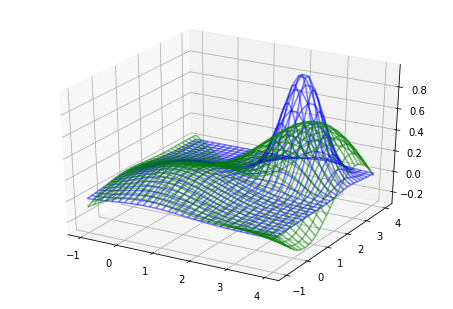

In [149]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, Z.reshape(X.shape), alpha=0.5, color='b')
ax.plot_wireframe(X, Y, mu.reshape(X.shape), alpha=0.5, color='g')


Обычная Байесовская оптимизация с обновлением параметров ядра (из коробки)

In [162]:
x_train = X_train.copy()
t_train = y_train.copy()
x_test = X_test
num_new_points = 30
for _ in range(num_new_points):
    # calculating expected improvement for all points
    gp.fit(x_train, -t_train)
    mu, sigma = gp.predict(x_test, True)
    expected_improvement = get_expected_improvement_sklearn(-t_train, mu, sigma)
    # adding new point
    x_train = np.vstack([x_train, np.array(x_test[np.argmax(expected_improvement)])])
    t_train = f(x_train)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [163]:
t_train[-30:]

array([0.24143105, 0.13966108, 0.86792187, 0.9646322 , 0.16495133,
       0.85181137, 0.97050359, 0.85674632, 0.97692904, 0.13498437,
       0.15980899, 0.2058709 , 0.13955047, 0.97692904, 0.10329674,
       0.97692904, 0.97692904, 0.97692904, 0.97692904, 0.97692904,
       0.97692904, 0.97692904, 0.97692904, 0.97692904, 0.97050359,
       0.97692904, 0.97692904, 0.97692904, 0.97692904, 0.97692904])

In [185]:
get_expected_improvement(x_train, t_train, x_train[-30:], np.exp(log_theta), beta, kernel)

array([4.72264024e-15, 4.72264024e-15, 4.72264024e-15, 4.72264024e-15,
       4.72264024e-15, 4.72264024e-15, 4.72264024e-15, 4.72264024e-15,
       4.72264024e-15, 4.72264024e-15, 4.72264024e-15, 4.72264024e-15,
       4.72264024e-15, 4.72264024e-15, 4.72264024e-15, 4.72264024e-15,
       4.72264024e-15, 4.72264024e-15, 4.72264024e-15, 4.72264024e-15,
       4.72264024e-15, 4.72264024e-15, 4.72264024e-15, 4.72264024e-15,
       4.72264024e-15, 4.72264024e-15, 4.72264024e-15, 4.72264024e-15,
       4.72264024e-15, 4.72264024e-15])

In [166]:
gp.fit(x_train, t_train)
mu, sigma = gp.predict(data, True)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


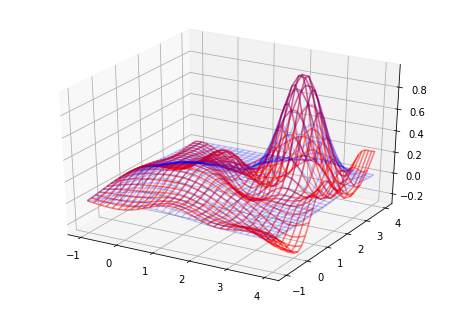

In [179]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, Z.reshape(X.shape), alpha=0.2, color='b')
ax.plot_wireframe(X, Y, mu.reshape(X.shape), alpha=0.5, color='r')


GP-UCB своя БО

In [213]:
x_train = X_train.copy()
t_train = y_train.copy()
x_test = X_test.copy()
lr = 1e-2
num_new_points = 30
forget = 1000
num_tuning_steps = 50
for _ in range(num_new_points):
    # model tuning  
    log_theta = np.log(np.array([10.0]))
    for _ in range(num_tuning_steps):
        grad = get_rbf_grad_log_theta(x_train, t_train, beta, np.exp(log_theta))
        log_theta = log_theta + lr*grad
    # calculating expected improvement for all points
    expected_improvement = get_gp_ucb_simple(x_train, t_train, x_test, theta, beta, forget, kernel)
    
    x_train = np.vstack([x_train, np.array(x_test[np.argmax(expected_improvement)])])
    t_train = f(x_train)

In [214]:
t_train[-30:]

array([0.13966108, 0.24402906, 0.10955087, 0.14213056, 0.21615607,
       0.10949271, 0.62755794, 0.62755794, 0.87452734, 0.87452734,
       0.87452734, 0.87452734, 0.87452734, 0.87452734, 0.87452734,
       0.87452734, 0.87452734, 0.87452734, 0.87452734, 0.87452734,
       0.87452734, 0.87452734, 0.87452734, 0.87452734, 0.87452734,
       0.87452734, 0.87452734, 0.87452734, 0.87452734, 0.87452734])

In [215]:
mu, sigma = predict(x_train, t_train, data, theta, beta, kernel)

In [216]:
get_gp_ucb_simple(x_train, t_train, x_train[:-30], theta, beta, forget, kernel)

array([0.76145026, 0.84546784, 0.96036849, 0.95981369, 0.97846623,
       1.01647447, 1.0097384 , 0.91344835, 0.75324369, 0.94023788,
       0.8646123 , 0.74939024, 1.06541781, 0.79302723, 0.92333056,
       1.08860099, 1.28084655, 0.9176605 , 0.90168667, 1.00283193,
       0.86230364, 0.92994532, 1.08189045])

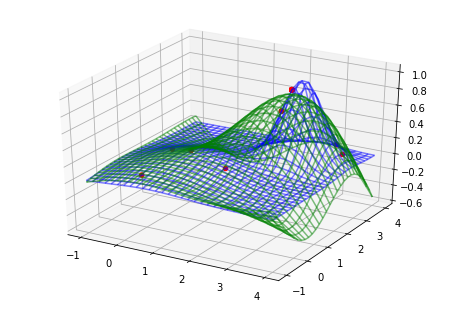

In [217]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, Z.reshape(X.shape), alpha=0.5, color='b')
ax.plot_wireframe(X, Y, mu.reshape(X.shape), alpha=0.5, color='g')
ax.scatter([x[0] for x in x_train[-30:]], [x[1] for x in x_train[-30:]], t_train[-30:], c='r',
        marker='o', alpha=1.0)

увеличим коэффициент забывания

In [196]:
x_train = X_train.copy()
t_train = y_train.copy()
x_test = X_test.copy()
lr = 1e-2
num_new_points = 15
forget = 1000
for _ in range(num_new_points):
    # model tuning  
    log_theta = np.log(np.array([10.0]))
    for _ in range(num_tuning_steps):
        grad = get_rbf_grad_log_theta(x_train, t_train, beta, np.exp(log_theta))
        log_theta = log_theta + lr*grad
    # calculating expected improvement for all points
    expected_improvement = get_gp_ucb_simple(x_train, t_train, x_test, theta, beta, forget, kernel)
    
    x_train = np.vstack([x_train, np.array(x_test[np.argmax(expected_improvement)])])
    t_train = f(x_train)

KeyboardInterrupt: 

GP-UCB  БО из коробки

In [203]:
x_train = X_train.copy()
t_train = y_train.copy()
x_test = X_test
num_new_points = 30
forget = 100
for _ in range(num_new_points):
    # calculating expected improvement for all points
    gp.fit(x_train, t_train)
    mu, sigma = gp.predict(x_test, True)
    expected_improvement = get_gp_ucb_simple_sklearn(mu, sigma, forget)
    # adding new point
    x_train = np.vstack([x_train, np.array(x_test[np.argmax(expected_improvement)])])
    t_train = f(x_train)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [204]:
t_train[-30:]

array([0.24143105, 0.13966108, 0.16495133, 0.76577471, 0.15980899,
       0.1258365 , 0.10955087, 0.13955047, 0.2058709 , 0.19329697,
       0.67185532, 0.10329674, 0.10949271, 0.15739112, 0.59009373,
       0.14869145, 0.1129344 , 0.87452734, 0.69732768, 0.9646322 ,
       0.97050359, 0.97692904, 0.97692904, 0.97692904, 0.97692904,
       0.97692904, 0.97692904, 0.97692904, 0.97692904, 0.97692904])

In [206]:
gp.fit(x_train, t_train)
mu, sigma = gp.predict(data, True)

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [201]:
get_gp_ucb_simple_sklearn(mu, sigma, forget)

array([-1.96355628e-01, -9.57753303e-02, -2.00250158e-01, -7.20092331e-01,
       -3.09440157e-01, -5.79939125e-01,  1.87233493e-02, -1.48230114e-01,
       -7.34169249e-03, -1.33290144e-01, -4.23258726e-02, -3.31617606e-02,
       -2.69415883e-01, -2.72101409e-02, -1.28948621e-01, -3.03719324e-01,
       -5.84539474e-01, -3.30851572e-01, -1.16160003e-01, -1.97636138e-02,
       -3.71044074e-02, -6.18484755e-02, -1.40620171e-01, -1.50948482e-01,
       -1.09392352e-01, -2.65029932e-02, -4.35387885e-01, -1.80247378e-01,
       -1.26900224e-01, -1.25032705e-01,  2.13549235e-02,  4.69050955e-02,
       -9.11007990e-02, -1.22149304e-01, -1.77770303e-01, -1.66558442e-01,
       -9.44654509e-02, -8.14136769e-02, -1.57322394e-01, -1.03195941e-01,
       -1.76086073e-01, -1.86201966e-01, -2.13337195e-01, -1.09450841e-01,
       -2.29359352e-02, -6.05016158e-02, -1.83126869e-01, -4.28514616e-01,
        6.69167068e-03,  4.72949711e-02, -1.14324572e-01, -7.75122736e-02,
       -1.94209349e-01, -

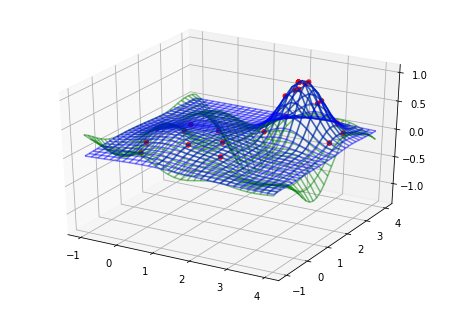

In [207]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, Z.reshape(X.shape), alpha=0.5, color='b')
ax.plot_wireframe(X, Y, mu.reshape(X.shape), alpha=0.5, color='g')
ax.scatter([x[0] for x in x_train[-30:]], [x[1] for x in x_train[-30:]], t_train[-30:], c='r',
        marker='o', alpha=1.0)

In [169]:
np.max(t_train)

0.2437866823615371

In [172]:
X_train

array([[ 0.11111111,  3.94949495],
       [ 3.64646465,  1.22222222],
       [ 2.28282828, -0.34343434],
       [ 0.31313131,  3.7979798 ],
       [ 3.39393939,  3.39393939],
       [-0.14141414,  1.97979798],
       [ 2.43434343,  1.47474747],
       [-0.29292929,  0.46464646],
       [ 1.22222222,  1.82828283],
       [ 2.33333333,  0.86868687],
       [-0.6969697 ,  2.43434343],
       [ 1.17171717,  0.06060606],
       [-0.7979798 ,  1.57575758],
       [ 2.68686869,  1.52525253],
       [ 2.58585859, -0.24242424],
       [ 2.98989899,  1.02020202],
       [ 0.11111111, -0.44444444],
       [ 3.34343434,  0.36363636],
       [ 2.38383838,  0.46464646],
       [-0.7979798 ,  0.26262626],
       [ 3.44444444,  1.97979798],
       [ 0.41414141, -0.64646465],
       [ 1.17171717,  2.78787879],
       [-0.39393939, -0.7979798 ],
       [ 1.27272727,  1.87878788],
       [ 0.26262626, -0.5959596 ],
       [ 2.38383838,  0.61616162],
       [ 2.73737374,  0.96969697],
       [-0.5959596 ,